In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file(
        'mini_speech_commands.zip',
        origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
        extract=True,
        cache_dir='.', cache_subdir='data')

In [3]:
commands = np.array(os.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print(commands)

['up' 'down' 'go' 'right' 'yes' 'left' 'stop' 'no']


In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
print('length of examples: {}'.format(len(filenames)))

length of examples: 8000


In [5]:
test_size = 800

train_files = filenames[:-test_size*2]
valid_files = filenames[-test_size*2:-test_size]
test_files = filenames[-test_size:]

print('Training set size', len(train_files))
print('Validation set size', len(valid_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [6]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

In [7]:
def get_labels(file_path):
    path_part = tf.strings.split(file_path, os.path.sep)
    return path_part[-2]

In [8]:
def get_wave_and_label(file_path):
    label = get_labels(file_path)
    audio_binary = tf.io.read_file(file_path)
    wave_form = decode_audio(audio_binary)
    
    return wave_form, label

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_files)
train_dataset = train_dataset.map(get_wave_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)

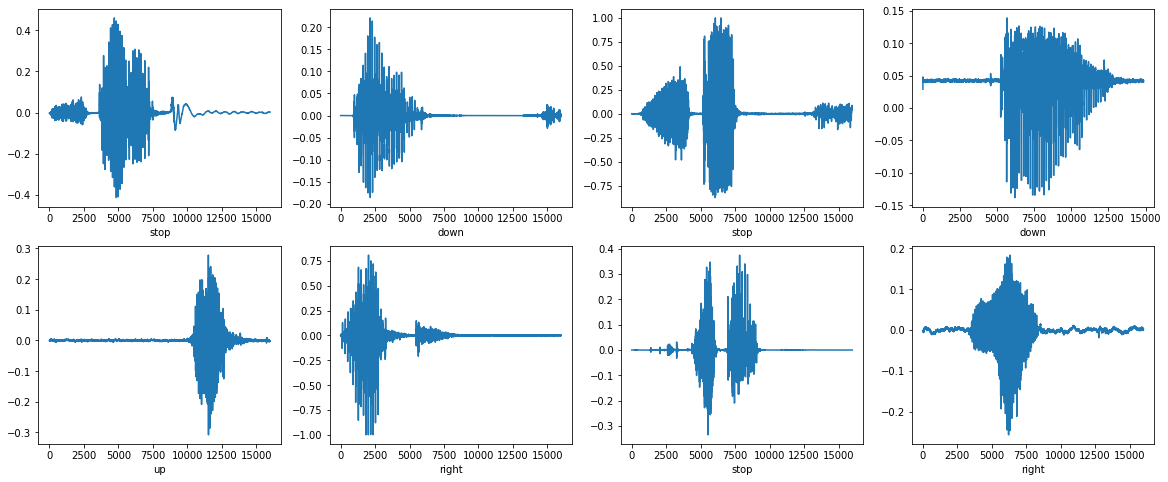

In [10]:
plt.figure(figsize=(20, 8))
for i, (audio, label) in enumerate(train_dataset.take(8)):
    plt.subplot(2, 4, i+1)
    plt.plot(audio.numpy())
    plt.xlabel(label.numpy().decode('utf-8'))

plt.show()

In [11]:
def get_spectrogram(wave_form):
    zero_padding = tf.zeros(16000 - tf.shape(wave_form), dtype=tf.float32)

    wave_form = tf.cast(wave_form, dtype=tf.float32)
    equal_length = tf.concat([wave_form, zero_padding], 0)
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)

    spectrogram = tf.abs(spectrogram)

    return spectrogram

In [12]:
for audio, label in train_dataset.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(audio)

    print(f'Label: {label}')
    print(f'spectrogram shape: {spectrogram.shape}')
    print(f'wave form shape: {audio.shape}')
    print()
    display.display(display.Audio(audio, rate=16000, autoplay=True))

Label: stop
spectrogram shape: (124, 129)
wave form shape: (16000,)



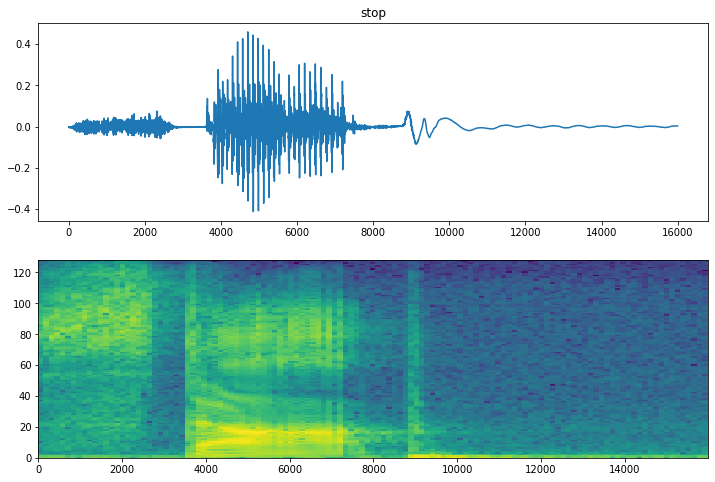

In [13]:
def plot_spectrogram(tensor, ax):
    spec_log = np.log(tensor.T)
    height = spec_log.shape[0]
    x = np.arange(16000, step=height+1)
    y = range(height)
    ax.pcolormesh(x, y, spec_log)

fig, axes = plt.subplots(2, figsize=(12, 8))

axes[0].plot(audio)
axes[0].set_title(label)

plot_spectrogram(spectrogram.numpy(), axes[1])

plt.show()

In [14]:
def get_spec_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)

    return spectrogram, label_id

In [15]:
spectrogram_ds = train_dataset.map(get_spec_and_label_id, num_parallel_calls=tf.data.experimental.AUTOTUNE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


[]

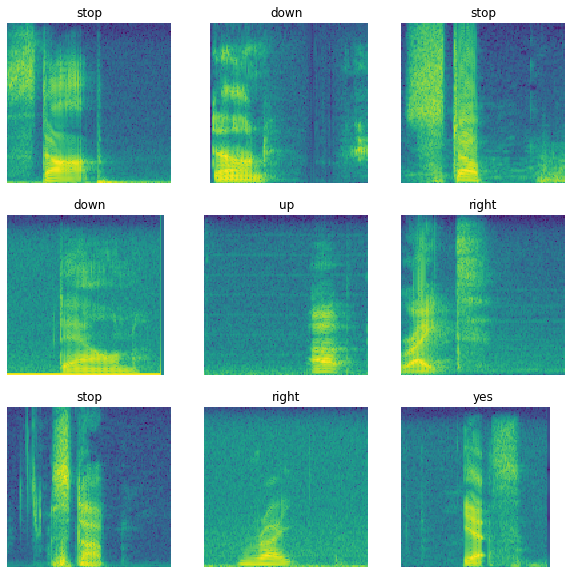

In [16]:
rows=3
cols=3

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spec, label_id) in enumerate(spectrogram_ds.take(rows*cols)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]

    plot_spectrogram(np.squeeze(spec.numpy()), ax)
    ax.set_title(commands[label_id.numpy()])
    ax.axis('off')

plt.plot()

In [17]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_wave_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    output_ds = output_ds.map(get_spec_and_label_id, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    return output_ds

In [18]:
train_dataset = spectrogram_ds
valid_dataset = preprocess_dataset(valid_files)
test_dataset = preprocess_dataset(test_files)

In [19]:
batch_size = 64
train_dataset = train_dataset.batch(batch_size)
valid_dataset = valid_dataset.batch(batch_size)

In [20]:
train_dataset = train_dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.cache().prefetch(tf.data.experimental.AUTOTUNE)

In [21]:
for spec, _ in spectrogram_ds.take(1):
    input_shape = spec.shape
    print('Input shape: {}'.format(input_shape))

num_labels = len(commands)

num_layer = preprocessing.Normalization()
num_layer.adapt(train_dataset.map(lambda x, _: x))

model = models.Sequential(name='Audio_recognition')

model.add(layers.Input(shape=input_shape))
model.add(preprocessing.Resizing(32, 32))
model.add(num_layer)
model.add(layers.Conv2D(32, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_labels))

model.summary()

Input shape: (124, 129, 1)
Model: "Audio_recognition"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)     

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [23]:
EPOCHS = 20

history = model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs=EPOCHS,
                        callbacks=[tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)])

Epoch 1/20
100/100 [==============================] - 4s 24ms/step - loss: 1.9985 - accuracy: 0.2348 - val_loss: 1.4674 - val_accuracy: 0.4737
Epoch 2/20
100/100 [==============================] - 0s 4ms/step - loss: 1.4389 - accuracy: 0.4809 - val_loss: 1.0819 - val_accuracy: 0.6125
Epoch 3/20
100/100 [==============================] - 0s 4ms/step - loss: 1.0829 - accuracy: 0.6184 - val_loss: 0.8791 - val_accuracy: 0.7075
Epoch 4/20
100/100 [==============================] - 0s 4ms/step - loss: 0.8753 - accuracy: 0.6798 - val_loss: 0.6796 - val_accuracy: 0.7850
Epoch 5/20
100/100 [==============================] - 0s 4ms/step - loss: 0.7265 - accuracy: 0.7419 - val_loss: 0.6112 - val_accuracy: 0.8037
Epoch 6/20
100/100 [==============================] - 0s 4ms/step - loss: 0.6306 - accuracy: 0.7771 - val_loss: 0.5504 - val_accuracy: 0.8200
Epoch 7/20
100/100 [==============================] - 0s 4ms/step - loss: 0.5685 - accuracy: 0.7980 - val_loss: 0.5130 - val_accuracy: 0.8250
Epoch

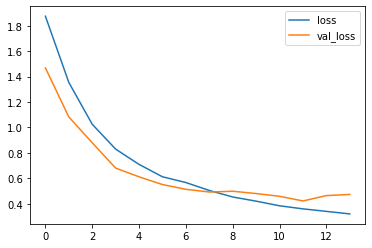

In [24]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [25]:
test_audio = []
test_labels = []

for audio, label in test_dataset:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [26]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 86%


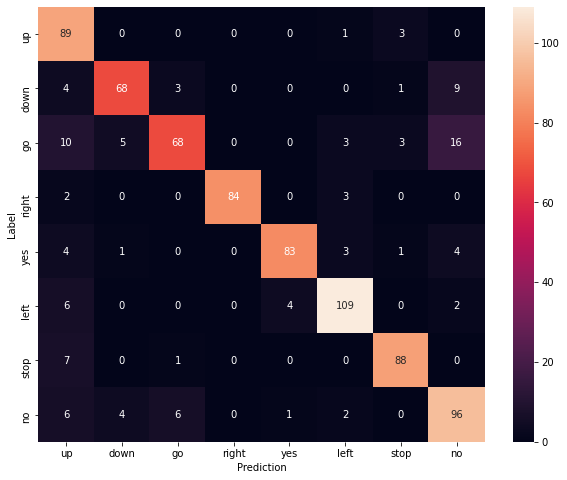

In [27]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

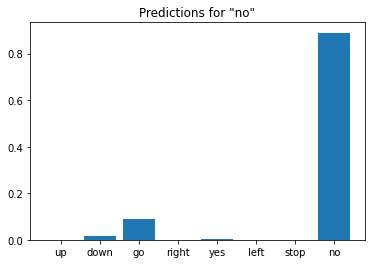

In [28]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()